In [41]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

In [42]:
# 读取处理后的数据（原始 + 抖音）
df1 = pd.read_csv("../processed_data/processed_psi_data.csv")
df2 = pd.read_csv("../processed_data/processed_psi_douyin.csv")

# 取共同列合并
common_cols = list(set(df1.columns) & set(df2.columns))
df = pd.concat([df1[common_cols], df2[common_cols]], ignore_index=True)
print(f"原始: {len(df1)} 行, 抖音: {len(df2)} 行, 合并: {len(df)} 行")

# 只使用抖音数据
# df = df1[common_cols]
# print(f"使用抖音数据: {len(df)} 行")

原始: 3372 行, 抖音: 4710 行, 合并: 8082 行


In [43]:
# 添加lag特征
for lag in [1, 2, 3, 4]:
    df[f"some_lag_{lag}"] = df["some_delta"].shift(lag)
    df[f"pgscan_lag_{lag}"] = df["pgscan_direct"].shift(lag)

# 删除因shift产生的NaN行
df = df.dropna().reset_index(drop=True)

In [44]:
# 时间序列分割
split = int(len(df) * 0.8)

train = df.iloc[:split]
test  = df.iloc[split:]

In [45]:
# 删除不参与训练的列 
drop_cols = [
    "ts",
    "source_file",
    "future_1s_some",
    "future_1s_full"
]

feature_cols = [c for c in df.columns if c not in drop_cols]

In [46]:
# 构造训练数据
X_train = train[feature_cols]
y_train = np.log1p(train["future_1s_full"])

X_test  = test[feature_cols]
y_test  = np.log1p(test["future_1s_full"])

In [47]:
# 训练XGBoost 模型
model = xgb.XGBRegressor(
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)


model.fit(X_train, y_train)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'reg:squarederror'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,0.8
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

In [48]:
# 预测
pred = model.predict(X_test)

In [49]:
# 评估
pred_real = np.expm1(pred)
y_real = np.expm1(y_test)

print("FULL R2 real:", r2_score(y_real, pred_real))
print("FULL MSE:", mean_squared_error(np.expm1(y_test), np.expm1(pred)))

FULL R2 real: 0.23471674138759013
FULL MSE: 273490589.4235346


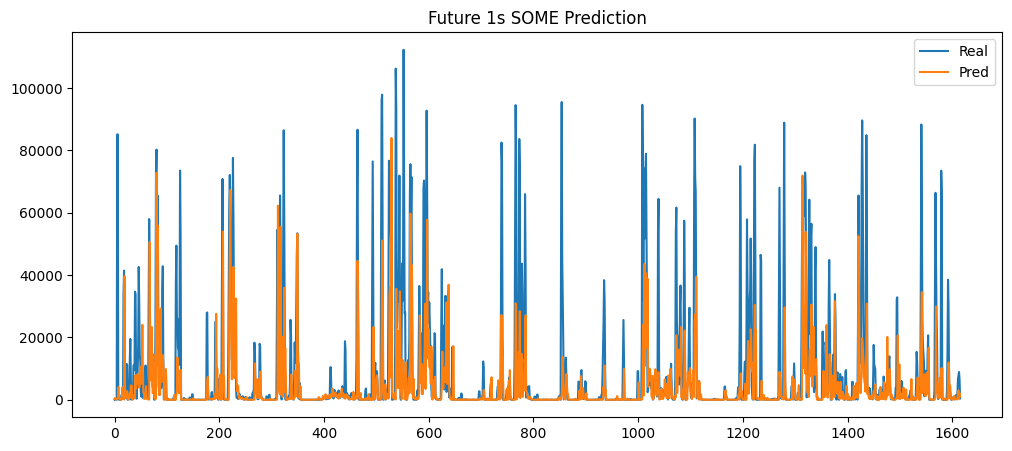

In [50]:
# 画图
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(np.expm1(y_test.values), label="Real")
plt.plot(np.expm1(pred), label="Pred")
plt.legend()
plt.title("Future 1s SOME Prediction")
plt.show()

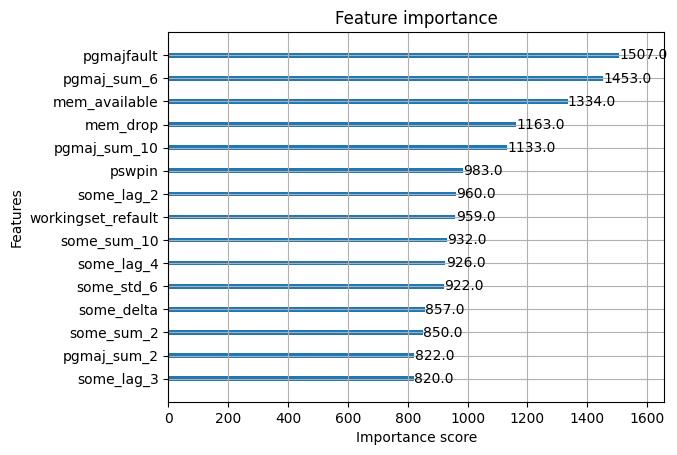

In [51]:
# 特征重要性
xgb.plot_importance(model, max_num_features=15)
plt.show()